### Time Series GARCH example

The following notebook is an example of fit of a GARCH(1,1) and a tGARCH(1,1) model 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import yfinance as yf
from datetime import datetime, timedelta
from time_series_functions import * # to import all the functions contained in the file/package

In [2]:
### Some useful functions

def get_last_working_date():
    
    today = datetime.now()
    last_working_day = today

    # Step back until a weekday (Monday to Friday) is found
    while last_working_day.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        last_working_day -= timedelta(days=1)
    
    return last_working_day

def data_retriver(tickers, start_date, end_date=None, interval='1d'):

    if end_date==None:
        end_date = get_last_working_date().strftime("%Y-%m-%d")
    
    combined_data = pd.DataFrame()
    
    for name, ticker in tickers.items():
        print(f"Processing {name} ({ticker})...")
        data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
        if not data.empty:
            combined_data[name] = data["Close"]
        else:
            print(f"Warning: No data found for {name} ({ticker}). Skipping.")
    
    combined_data = combined_data.interpolate(method='linear')
    
    return combined_data

In [3]:
# List of major stock index tickers
# indexes = {
#     "S&P 500 (US)": "^GSPC",
#     "Dow Jones (US)": "^DJI",
#     "Nasdaq (US)": "^IXIC",
#     "Russell 2000 (US)": "^RUT",
#     "FTSE 100 (UK)": "^FTSE",
#     "DAX (Germany)": "^GDAXI",
#     "CAC 40 (France)": "^FCHI",
#     "Euro Stoxx 50 (Europe)": "^STOXX50E",
#     "IBEX 35 (Spain)": "^IBEX",
#     "FTSE MIB (Italy)": "FTSEMIB.MI",
#     "AEX (Netherlands)": "^AEX"
# }

indexes = {
    "S&P 500 (US)": "^GSPC"}

# Define the date range
start_date = "2010-01-04"
end_date = get_last_working_date().strftime("%Y-%m-%d")

# Loop through the tickers and add adjusted close data to the combined DataFrame

combined_data = pd.DataFrame()

for name, ticker in indexes.items():
    print(f"Processing {name} ({ticker})...")
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    if not data.empty:
        combined_data[name] = data["Close"]
    else:
        print(f"Warning: No data found for {name} ({ticker}). Skipping.")

Processing S&P 500 (US) (^GSPC)...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
np.round(combined_data.head(15),4)

,S&P 500 (US)
Date,
2010-01-04,1132.9900
2010-01-05,1136.5200
2010-01-06,1137.1400
2010-01-07,1141.6899
2010-01-08,1144.9800
2010-01-11,1146.9800
2010-01-12,1136.2200
2010-01-13,1145.6801
2010-01-14,1148.4600


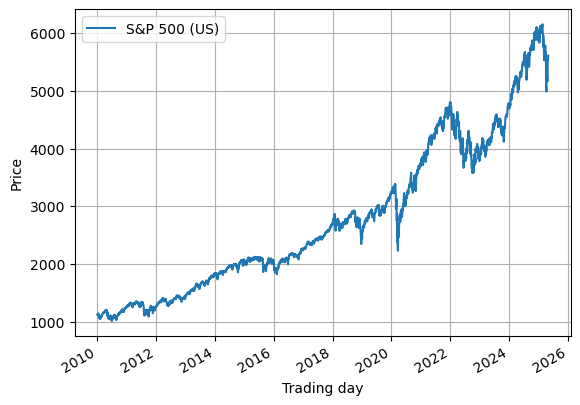

In [5]:
combined_data.plot()
plt.grid()
plt.ylabel('Price')
plt.xlabel('Trading day')
plt.show()

In [6]:
# Let's compute the log-returns 

df_returns = np.log(combined_data).diff().dropna()
df_returns.head(10)

,S&P 500 (US)
Date,
2010-01-05,0.003111
2010-01-06,0.000545
2010-01-07,0.003993
2010-01-08,0.002878
2010-01-11,0.001745
2010-01-12,-0.009425
2010-01-13,0.008291
2010-01-14,0.002423
2010-01-15,-0.010882


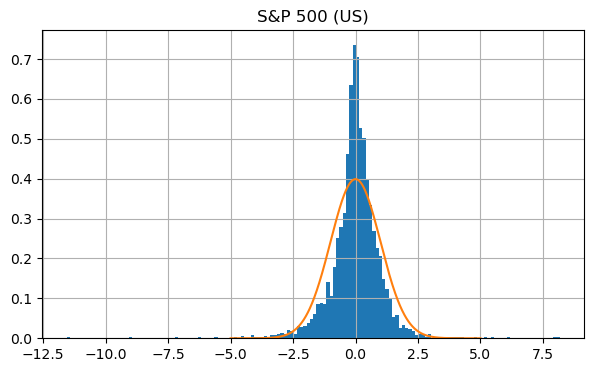

In [7]:
# Let's check the distributions

x = np.linspace(-5, 5, 1000)
gauss_pdf = norm.pdf(x)

for item in df_returns.columns:

    rt = df_returns[item].values
    std_rt = (rt - np.mean(rt))/np.std(rt) # let's standardized the log-returns 
    
    plt.figure(figsize=(7,4))
    plt.hist(std_rt, bins=150, density=True)
    plt.plot(x, gauss_pdf)
    plt.grid()
    plt.title(item)
    plt.show()
    

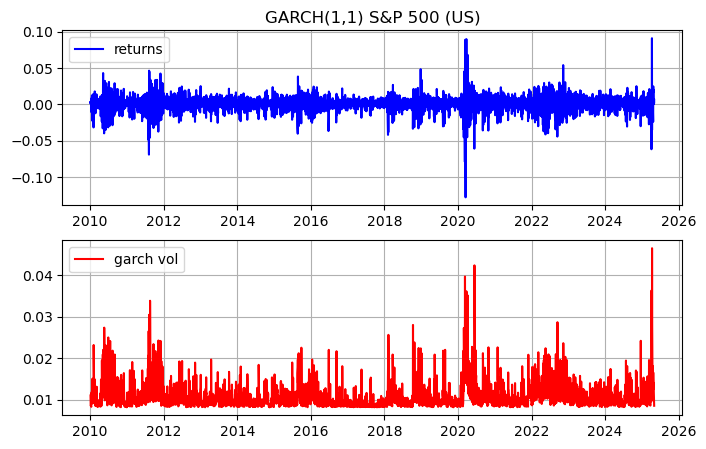

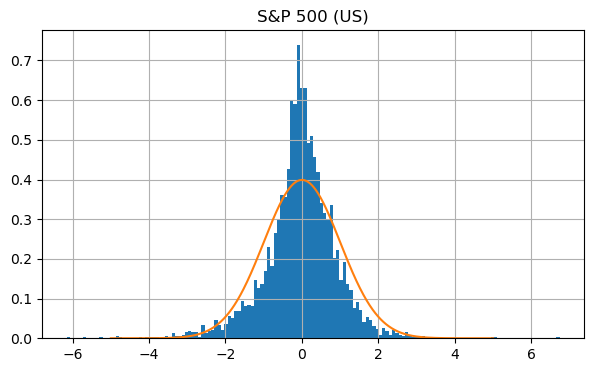

In [8]:
for item in df_returns.columns:

        rt = df_returns[item].values 
        
        params = [0, 0.0002, 0.1, .2, 0.0002]
        params[1:] = np.log(params[1:])
        fitted_params, fun, grad, sigma_square, eps = fit(params, rt.flatten(), 1, 1, 'normal', method='BFGS')
        
        # params = [0, 0.0002, 0.1, .2, 5, 0.0002] # for the student-t
        # params[1:] = np.log(params[1:])
        # fitted_params, fun, grad, sigma_square, eps = fit(params, rt.flatten(), 1, 1, 't', method='BFGS')
    
        fig, axes = plt.subplots(2, 1, figsize=(8, 5))
        # Top-left plot
        axes[0].plot(df_returns[item].index, rt, label='returns', color='blue')
        axes[0].set_title('GARCH(1,1) '+item)
        axes[0].legend()
        axes[0].grid()
        
        # Bottom-left plot
        axes[1].plot(df_returns[item].index, np.sqrt(sigma_square), label='garch vol', color='red')
        axes[1].set_title(" ")
        axes[1].legend()
        axes[1].grid() 
        plt.show() 
        
        plt.figure(figsize=(7,4))
        plt.hist(eps, bins=150, density=True)
        plt.plot(x, gauss_pdf)
        plt.grid()
        plt.title(item)
        plt.show() 
        
        break
    

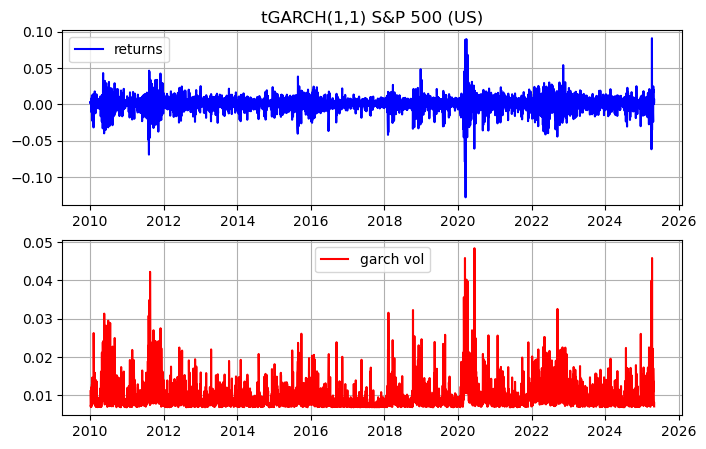

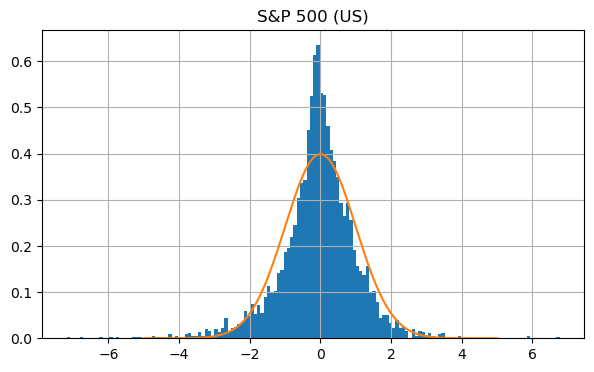

KeyError: 'mu'

In [9]:
for item in df_returns.columns:

        rt = df_returns[item].values
        
        params = [0, 0.0002, 0.1, .2, 5, 0.0002] # for the student-t
        params[1:] = np.log(params[1:])
        fitted_params, fun, grad, sigma_square, eps = fit(params, rt.flatten(), 1, 1, 't', method='BFGS')
    
        fig, axes = plt.subplots(2, 1, figsize=(8, 5))
        # Top-left plot
        axes[0].plot(df_returns[item].index, rt, label='returns', color='blue')
        axes[0].set_title('tGARCH(1,1) '+item)
        axes[0].legend()
        axes[0].grid()
        
        # Bottom-left plot
        axes[1].plot(df_returns[item].index, np.sqrt(sigma_square), label='garch vol', color='red')
        axes[1].set_title(" ")
        axes[1].legend()
        axes[1].grid() 
        plt.show() 
    
        plt.figure(figsize=(7,4))
        plt.hist(eps, bins=150, density=True)
        plt.plot(x, gauss_pdf)
        plt.grid()
        plt.title(item)
        plt.show() 

        mu = fitted_params['mu']
        omega = fitted_params['omega']
        alphas =  np.array([fitted_params['alpha_1']])
        phis = np.array([fitted_params['phi_1']])
        sigma_square0 = fitted_params['sigma_square0']
        
        break
    